In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist_data = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def discriminator(images, reuse=False):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse) as scope:
    
        # First Convolutional and pool layers
        # This finds 32 different 5*5 features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1,1,1,1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # Second Convolutional layer
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1,1,1,1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # First Fully Connected layer
        d_w3 = tf.get_variable('d_w3', [7*7*64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7*7*64]) # Flatten
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Last Output layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        return d4

In [4]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02)) # 3136 = 28*28*2*2
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)
    
    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])
    
    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1,2,2,1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])
    
    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimension of g4: batch_size * 28 * 28 * 1
    return g4

In [5]:
z_dimensions = 100 
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [6]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

In [7]:
tf.reset_default_graph()
batch_size = 50

# z_placeholder is for feeding input noise to the "generator"
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
# x_placeholder is for feeding input images to the "discriminator"
x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name='x_placeholder')

# Gz holds the generated images
Gz = generator(z_placeholder, batch_size, z_dimensions)

# Dx will hold discriminator prediction probabilities
# for the real MNIST images
Dx = discriminator(x_placeholder)

# Dg will hold discriminator prediction probabilities for generated images
Dg = discriminator(Gz, reuse=True)

In [8]:
# Compare real images loss probabilities : 1 <-> Dx output
# tf.ones_like : Make same shape of 1 matrix
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))

# Compare fake images loss probabilities : 0 <-> Dg outut
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

In [9]:
# generator wants the discriminator to output a value close to 1 when it's given an image from the generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [10]:
tvars = tf.trainable_variables()
d_tvars = [var for var in tvars if 'd_' in var.name]
g_tvars = [var for var in tvars if 'g_' in var.name]

print(d_tvars)
print(g_tvars)

[<tf.Variable 'd_w1:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'd_b1:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'd_w2:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'd_b2:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'd_w3:0' shape=(3136, 1024) dtype=float32_ref>, <tf.Variable 'd_b3:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'd_w4:0' shape=(1024, 1) dtype=float32_ref>, <tf.Variable 'd_b4:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'g_w1:0' shape=(100, 3136) dtype=float32_ref>, <tf.Variable 'g_b1:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'g_w2:0' shape=(3, 3, 1, 50) dtype=float32_ref>, <tf.Variable 'g_b2:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'g_w3:0' shape=(3, 3, 50, 25) dtype=float32_ref>, <tf.Variable 'g_b3:0' shape=(25,) dtype=float32_ref>, <tf.Variable 'g_w4:0' shape=(1, 1, 25, 1) dtype=float32_ref>, <tf.Variable 'g_b4:0' shape=(1,) dtype=float32_ref>]


In [11]:
# Disciminator trainer
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_tvars)
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_tvars)

# Generator trainer
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_tvars)

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_Image', images_for_tensorboard, 5)
merged = tf.summary.merge_all()

logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
writer = tf.summary.FileWriter(logdir, sess.graph)

In [13]:
last_checkpoint_steps = 60000

saver = tf.train.Saver()
saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt-{}'.format(last_checkpoint_steps))

# z_batch = np.random.normal(0, 1, [10, z_dimensions])
# z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
# generated_images = generator(z_placeholder, 10, z_dimensions)
# images = sess.run(generated_images, feed_dict={z_placeholder:z_batch})
# for i in range(10):
#     plt.imshow(images[i].reshape([28, 28]), cmap='gray')
#     plt.show()

INFO:tensorflow:Restoring parameters from pretrained-model/pretrained_gan.ckpt-60000


i : 60000, at : 2017-09-07 14:35:07.318970


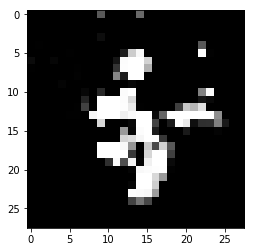

Estimated result : [[ 124.77159119]]
i : 61000, at : 2017-09-07 14:36:28.456243


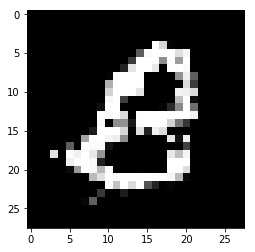

Estimated result : [[ 6.30545044]]
i : 62000, at : 2017-09-07 14:37:49.330048


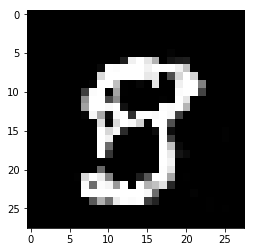

Estimated result : [[ 45.90929794]]
i : 63000, at : 2017-09-07 14:39:10.129163


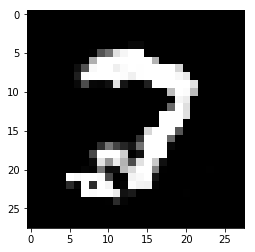

Estimated result : [[ 126.90563965]]
i : 64000, at : 2017-09-07 14:40:31.041301


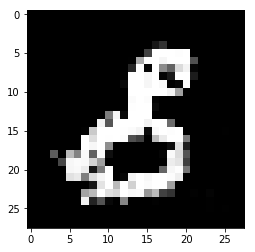

Estimated result : [[-34.80829239]]
i : 65000, at : 2017-09-07 14:41:51.925538


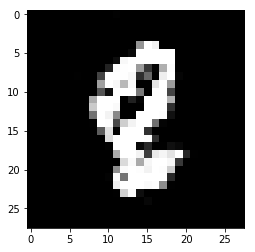

Estimated result : [[-55.69921875]]
i : 66000, at : 2017-09-07 14:43:12.805107


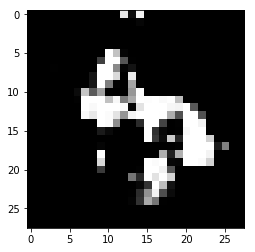

Estimated result : [[ 114.63750458]]
i : 67000, at : 2017-09-07 14:44:33.682258


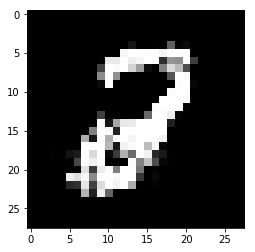

Estimated result : [[ 7.08066559]]
i : 68000, at : 2017-09-07 14:45:54.705293


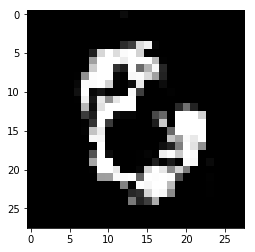

Estimated result : [[-91.08307648]]
i : 69000, at : 2017-09-07 14:47:15.620824


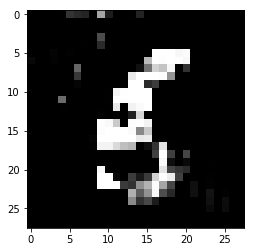

Estimated result : [[-39.45474243]]
i : 70000, at : 2017-09-07 14:48:36.574251


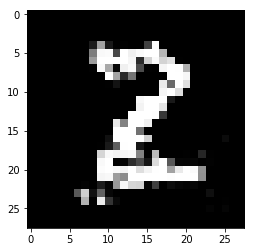

Estimated result : [[ 28.88783836]]
i : 71000, at : 2017-09-07 14:49:57.852169


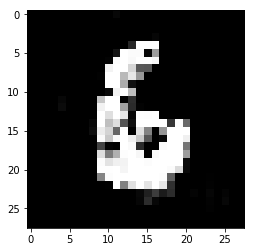

Estimated result : [[ 55.94890213]]
i : 72000, at : 2017-09-07 14:51:18.692652


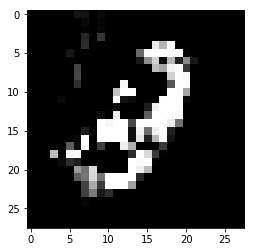

Estimated result : [[-102.57580566]]
i : 73000, at : 2017-09-07 14:52:39.716789


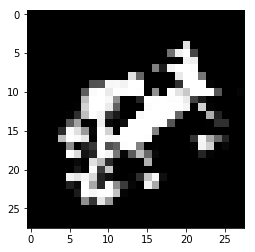

Estimated result : [[-6.7698288]]
i : 74000, at : 2017-09-07 14:54:00.469178


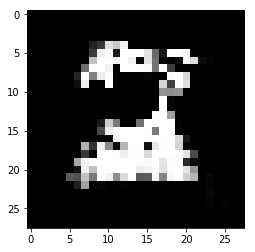

Estimated result : [[ 27.99175072]]
i : 75000, at : 2017-09-07 14:55:21.380397


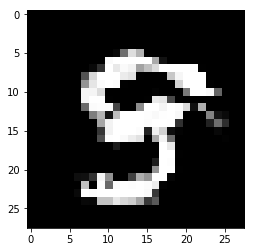

Estimated result : [[ 63.91688156]]
i : 76000, at : 2017-09-07 14:56:42.241608


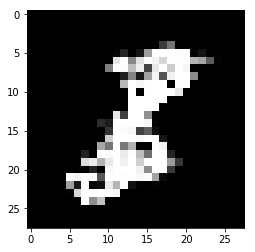

Estimated result : [[ 121.52291107]]
i : 77000, at : 2017-09-07 14:58:03.059985


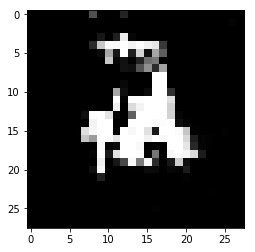

Estimated result : [[ 11.19525146]]
i : 78000, at : 2017-09-07 14:59:24.051655


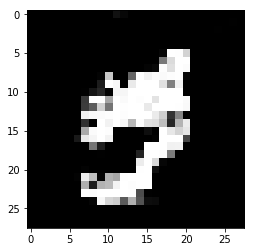

Estimated result : [[ 2.27502251]]
i : 79000, at : 2017-09-07 15:00:44.959461


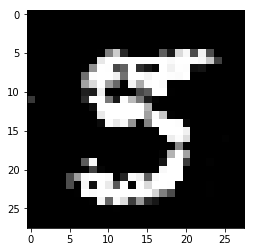

Estimated result : [[ 161.37709045]]
i : 80000, at : 2017-09-07 15:02:05.841689


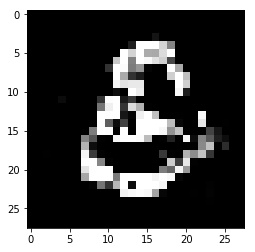

Estimated result : [[-89.41088104]]
i : 81000, at : 2017-09-07 15:03:27.213454


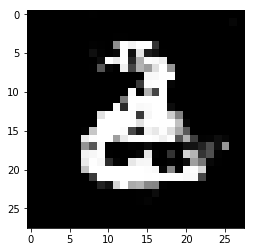

Estimated result : [[ 28.34025192]]
i : 82000, at : 2017-09-07 15:04:48.075346


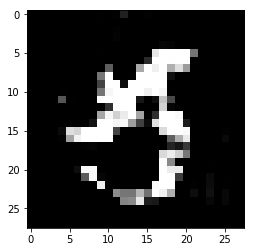

Estimated result : [[-59.9486351]]
i : 83000, at : 2017-09-07 15:06:08.914213


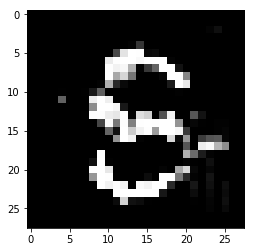

Estimated result : [[ 205.69406128]]
i : 84000, at : 2017-09-07 15:07:29.841950


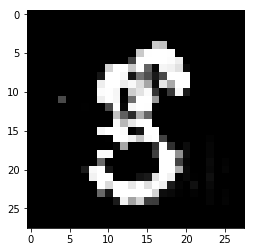

Estimated result : [[-26.24589348]]
i : 85000, at : 2017-09-07 15:08:50.745209


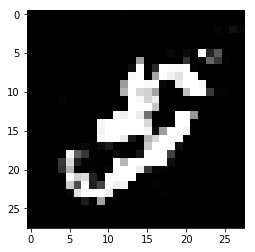

Estimated result : [[ 228.38574219]]
i : 86000, at : 2017-09-07 15:10:11.588555


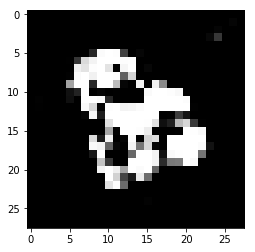

Estimated result : [[-42.69380951]]
i : 87000, at : 2017-09-07 15:11:32.428862


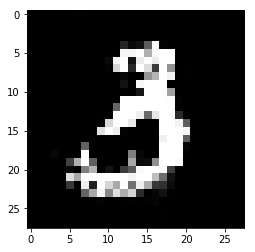

Estimated result : [[ 112.23777771]]
i : 88000, at : 2017-09-07 15:12:53.523630


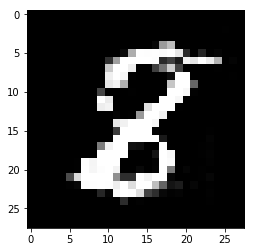

Estimated result : [[-19.27409744]]
i : 89000, at : 2017-09-07 15:14:14.433616


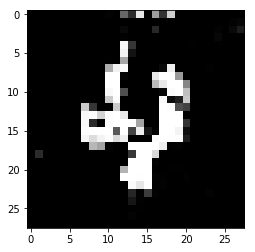

Estimated result : [[ 61.51431656]]
i : 90000, at : 2017-09-07 15:15:35.395957


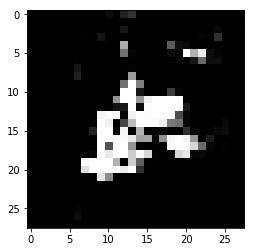

Estimated result : [[ 121.38062286]]
i : 91000, at : 2017-09-07 15:16:56.883574


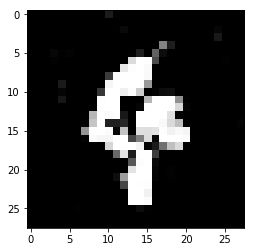

Estimated result : [[ 19.88271332]]
i : 92000, at : 2017-09-07 15:18:17.888945


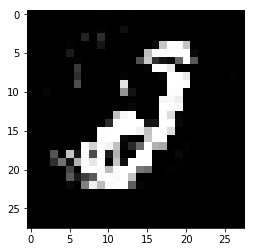

Estimated result : [[-92.91339874]]
i : 93000, at : 2017-09-07 15:19:38.899554


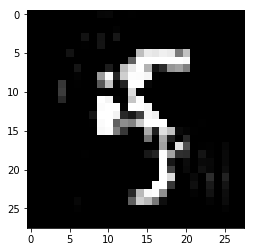

Estimated result : [[ 58.11846161]]
i : 94000, at : 2017-09-07 15:20:59.876852


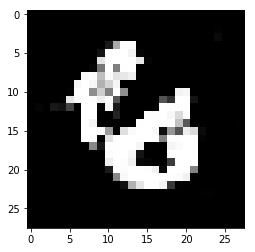

Estimated result : [[ 71.46956635]]
i : 95000, at : 2017-09-07 15:22:20.777895


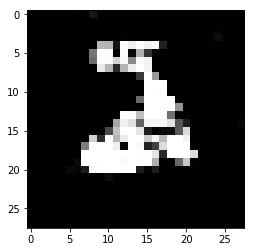

Estimated result : [[ 0.34247819]]
i : 96000, at : 2017-09-07 15:23:42.002379


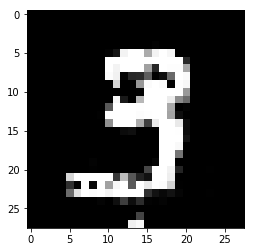

Estimated result : [[ 230.30088806]]
i : 97000, at : 2017-09-07 15:25:02.929213


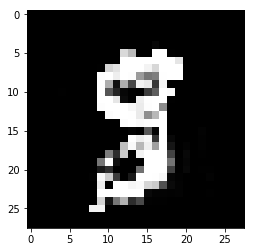

Estimated result : [[ 55.29975128]]
i : 98000, at : 2017-09-07 15:26:23.779459


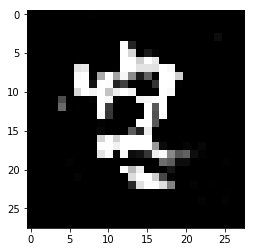

Estimated result : [[-120.20614624]]
i : 99000, at : 2017-09-07 15:27:44.803948


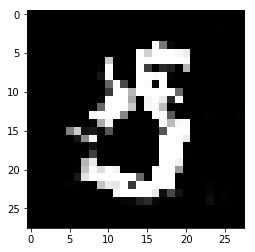

Estimated result : [[-187.07824707]]


In [14]:
for i in range(last_checkpoint_steps, 100000):
    # train discriminator
    z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
    real_image_batch = mnist_data.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, _, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake], 
                                          feed_dict={x_placeholder:real_image_batch, z_placeholder:z_batch})
    
    # train generator
    z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder:z_batch})
    
    if i % 100 == 0:
        # Update tensorboard
        z_batch = np.random.normal(0, 1, [batch_size, z_dimensions])
        summary = sess.run(merged, feed_dict={z_placeholder:z_batch, x_placeholder:real_image_batch})
        writer.add_summary(summary, i)
        
    if i % 1000 == 0:
        # Every 1000 iters, show generated images
        print("i : {}, at : {}".format(i, datetime.datetime.now()))
        z_batch = np.random.normal(0, 1, [1, z_dimensions])
        generating_image_tensor = generator(z_placeholder, 1, z_dimensions)
        generated_image = sess.run(generating_image_tensor, feed_dict={z_placeholder:z_batch})
        plt.imshow(generated_image[0].reshape([28,28]), cmap='gray')
        plt.show()
        
        # Show discriminator's estimate
        im = generated_image[0].reshape([1, 28, 28, 1])
        discriminator_result_tensor = discriminator(x_placeholder)
        estimate_result = sess.run(discriminator_result_tensor, feed_dict={x_placeholder:im})
        print("Estimated result : {}".format(estimate_result))
    
    if i % 10000 == 0:
        # Save weights
        saver.save(sess, 'pretrained-model/pretrained_gan.ckpt', global_step=i)